<a href="https://colab.research.google.com/github/gibi177/NOIA/blob/main/Reconhecimento_de_digital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento de digital

## Trabalho final da disciplina Noções de Inteligência Artificial - 2/2024
## Alunos: Felipe Lopes Gibin Duarte (231025207) e Matheus das Neves Fernandes (231013672)


## Introdução

O reconhecimento de digitais é uma tecnologia essencial no mundo contemporâneo, sendo amplamente utilizada em aplicações como o desbloqueio de dispositivos móveis e o controle de acesso a informações confidenciais. Neste trabalho, resolveremos o problema de reconhecimento de digitais desenvolvendo uma rede neural capaz de distinguir digitais reais de falsificadas, utilizando o dataset FVC2000 DB4. Para isso, será aplicada a técnica do transfer learning com a arquitetura da ResNet50. Visamos demonstrar a versatilidade e aplicabilidade de redes neurais na tarefa de reconhecimento de imagens.

## 1. Preparação do ambiente

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [2]:
!pip install opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: felipegibin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b


100%|██████████| 25.9M/25.9M [00:00<00:00, 82.7MB/s]


In [3]:
# Configurações
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
train_data_path = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data"
real_data_path = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data"

In [4]:
import os
import shutil

# Caminho do diretório de treino
train_data_path = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data"

# Caminho de destino dentro de train_data_path
output_dir = train_data_path

# Listar todos os arquivos no diretório train_data
for file_name in os.listdir(train_data_path):
    if file_name.endswith('.bmp'):
        # Extraímos a identificação da pessoa (primeiros 5 caracteres do nome do arquivo)
        person_id = file_name[:5]

        # Cria o diretório para a pessoa, se não existir
        person_dir = os.path.join(output_dir, person_id)
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # Caminho completo do arquivo original
        src_file = os.path.join(train_data_path, file_name)

        # Caminho completo de destino
        dst_file = os.path.join(person_dir, file_name)

        # Move o arquivo para o diretório correto
        shutil.move(src_file, dst_file)

print("Reorganização concluída!")


Reorganização concluída!


Caminhos das primeiras 5 digitais:
['/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_74.bmp', '/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_78.bmp', '/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_57.bmp', '/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_02.bmp', '/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_09.bmp']


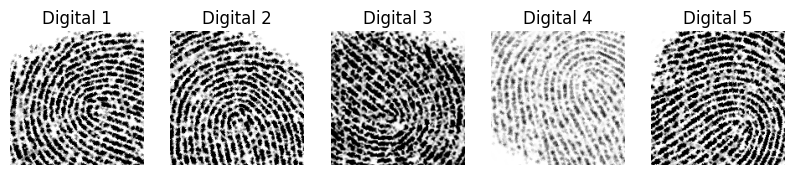

In [5]:
# Caminho para as digitais da pessoa com id 00000
person_0_path = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000"

# Listar todas as imagens no diretório
person_0_digitals = [os.path.join(person_0_path, img) for img in os.listdir(person_0_path) if img.endswith(".bmp")]

# Exibir os caminhos das primeiras 3 digitais da pessoa 0
print("Caminhos das primeiras 5 digitais:")
print(person_0_digitals[:5])

# Função para exibir as imagens
def show_images(image_paths, num_images=3):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = image.load_img(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Digital {i + 1}")
        plt.axis('off')
    plt.show()

# Exibir as primeiras 5 digitais
show_images(person_0_digitals, num_images=5)

### Pares de verificação
A função a seguir retorna duas listas:

pairs: Lista de tuplas, onde cada tupla contém dois caminhos de arquivos de imagem (um para a imagem de referência e outro para a imagem correspondente).

labels: Lista de labels (1 ou 0), indicando se as duas imagens no par são da mesma pessoa (1) ou pessoas diferentes (0).

In [8]:
# Função para criar pares de verificação
def create_verification_pairs(real_dir, train_dir, num_negatives_per_positive=1):
    pairs = []
    labels = []

    # Lista de pessoas (00000 a 00009)
    person_ids = [f"{i:05d}" for i in range(10)]

    for person_id in person_ids:
        # Imagem de referência (real_data)
        anchor_path = os.path.join(real_dir, f"{person_id}.bmp")

        # Pares POSITIVOS (mesma pessoa)
        positive_dir = os.path.join(train_dir, person_id)
        for img_name in os.listdir(positive_dir):
            if img_name.endswith(".bmp"):
                pairs.append((anchor_path, os.path.join(positive_dir, img_name)))
                labels.append(1)

        # Pares NEGATIVOS (pessoas diferentes)
        other_ids = [id for id in person_ids if id != person_id]
        for _ in range(num_negatives_per_positive * 80):  # Balanceamento
            other_id = random.choice(other_ids)
            other_dir = os.path.join(train_dir, other_id)
            other_img = random.choice(os.listdir(other_dir))
            pairs.append((anchor_path, os.path.join(other_dir, other_img)))
            labels.append(0)

    return pairs, labels

# Criar pares
pairs, labels = create_verification_pairs(real_data_path, train_data_path)

### Pré-processamento das imagens


In [9]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Dataset TensorFlow
def create_dataset(pairs, labels):
    anchor_images = []
    test_images = []
    for anchor, test in pairs:
        anchor_images.append(preprocess_image(anchor))
        test_images.append(preprocess_image(test))

    return tf.data.Dataset.from_tensor_slices((
        (tf.stack(anchor_images), tf.stack(test_images)),
        tf.convert_to_tensor(labels, dtype=tf.float32)
    )).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Divisão treino/validação
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    pairs, labels, test_size=0.2, random_state=42
)

train_ds = create_dataset(train_pairs, train_labels)
val_ds = create_dataset(val_pairs, val_labels)

## Arquitetura da rede

In [16]:
def build_siamese_model():
    # Base network compartilhada
    input_layer = layers.Input(shape=(160, 160, 3))  # Alterado para 160x160

    x = layers.Conv2D(64, (3,3), activation='relu')(input_layer)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='sigmoid')(x)

    base_model = Model(input_layer, x)

    # Duas entradas
    anchor_input = layers.Input(shape=(160, 160, 3), name='anchor_input')  # Alterado para 160x160
    test_input = layers.Input(shape=(160, 160, 3), name='test_input')  # Alterado para 160x160

    # Embeddings
    anchor_embedding = base_model(anchor_input)
    test_embedding = base_model(test_input)

    # Distância L1
    distance = layers.Lambda(
        lambda embeddings: tf.abs(embeddings[0] - embeddings[1])
    )([anchor_embedding, test_embedding])

    # Classificação
    output = layers.Dense(1, activation='sigmoid')(distance)

    return Model(inputs=[anchor_input, test_input], outputs=output)

# Criar o modelo
model = build_siamese_model()

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor_input (InputLayer) │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ test_input (InputLayer)   │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 256)            │        108,672 │ anchor_input[0][0],    │
│                           │                        │                │ test_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 256)            │              0 │ functional_2[0][0],    │
│                           │                        │                │ functional_2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            257 │ lambda_1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 108,929 (425.50 KB)

 Trainable params: 108,929 (425.50 KB)

 Non-trainable params: 0 (0.00 B)

## Treinamento

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.5255 - loss: 0.6918 - val_accuracy: 0.4875 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5459 - loss: 0.6778 - val_accuracy: 0.4875 - val_loss: 0.6846 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5569 - loss: 0.6731 - val_accuracy: 0.5469 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5870 - loss: 0.6665 - val_accuracy: 0.6156 - val_loss: 0.6643 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5901 - loss: 0.6699 - val_accuracy: 0.6187 - val_loss: 0.6493 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5955 - loss: 0.6516 - val_accuracy: 0.6219 - val_loss: 0.6381 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5468 - loss: 0.6710 - val_acc

In [36]:
def verify_fingerprint(anchor_path, test_path, threshold=0.5):
    # Pré-processamento
    anchor = preprocess_image(anchor_path)
    test = preprocess_image(test_path)

    # Predição
    similarity = model.predict([tf.expand_dims(anchor, 0), tf.expand_dims(test, 0)])[0][0]

    # Decisão
    if similarity > threshold:
        return f"Digital VERIFICADA (similaridade: {similarity:.2f})"
    else:
        return f"FALSIFICAÇÃO detectada (similaridade: {similarity:.2f})"

# Exemplo de uso:

#Verificada
anchor_example1 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data/00001.bmp"
test_example1 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00001/00001_06.bmp"

#Falsificada
anchor_example2 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data/00007.bmp"
test_example2 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00008/00008_70.bmp"

#Verificada
anchor_example3 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data/00003.bmp"
test_example3 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00003/00003_65.bmp"

#Falsificada
anchor_example4 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data/00004.bmp"
test_example4 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00005/00005_79.bmp"

result1 = verify_fingerprint(anchor_example1, test_example1)
result2 = verify_fingerprint(anchor_example2, test_example2)
result3 = verify_fingerprint(anchor_example3, test_example3)
result4 = verify_fingerprint(anchor_example4, test_example4)

print(result1)
print(result2)
print(result3)
print(result4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Digital VERIFICADA (similaridade: 0.63)
Digital VERIFICADA (similaridade: 0.51)
Digital VERIFICADA (similaridade: 0.66)
FALSIFICAÇÃO detectada (similaridade: 0.47)


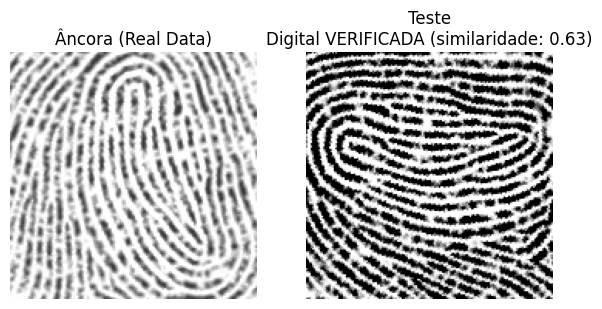

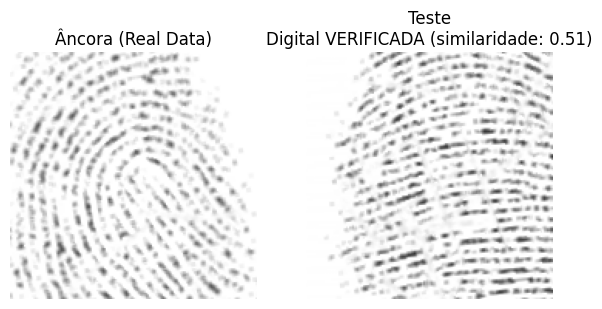

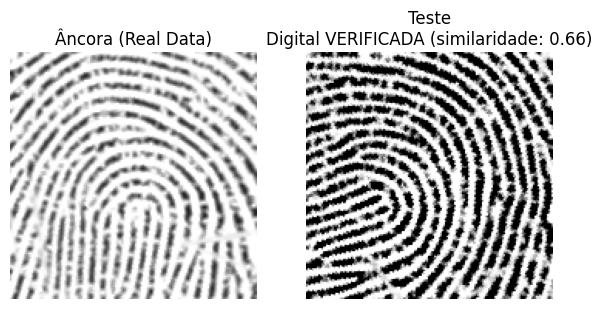

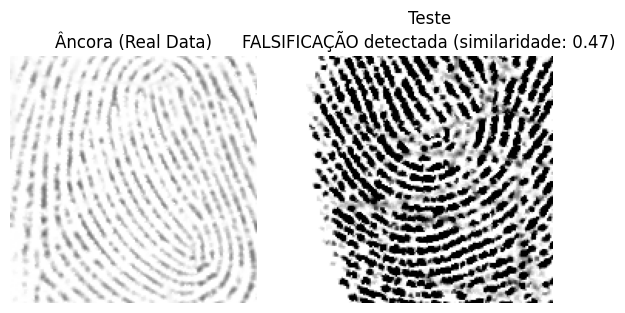

In [38]:
# Plotar pares
def plot_pairs(anchor, test, prediction):
    plt.figure(figsize=(7,5))

    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.load_img(anchor))
    plt.title("Âncora (Real Data)")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.load_img(test))
    plt.title(f"Teste\n{prediction}")
    plt.axis('off')

    plt.show()

# Testar com exemplos
plot_pairs(anchor_example1, test_example1, result1)
plot_pairs(anchor_example2, test_example2, result2)
plot_pairs(anchor_example3, test_example3, result3)
plot_pairs(anchor_example4, test_example4, result4)